In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Aug 20 20:22:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   46C    P0    71W / 300W |   8453MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [3]:
n_mels = 80
n_outputs = 61
n_frames = 400

In [4]:
from model.model_conditional_transformer_reg import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, h_dim=512, out_dim=n_outputs)
model = model.to(device)
model.eval()
print('done')

done


In [5]:
!ls -lt /data/scpark/save/lips/train08.14-1/

total 21289360
-rw-rw-r-- 1 scpark scpark        40  8월 17 11:12 events.out.tfevents.1692157154.GPUSVR11
-rw-rw-r-- 1 scpark scpark      5782  8월 17 11:12 events.out.tfevents.1692157190.GPUSVR11
-rw-rw-r-- 1 scpark scpark 531711057  8월 17 08:02 save_180000
-rw-rw-r-- 1 scpark scpark 531711057  8월 17 03:24 save_170000
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 23:11 save_160000
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 19:42 save_150000
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 16:14 save_140000
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 12:41 save_130000
-rw-rw-r-- 1 scpark scpark        40  8월 16 12:38 events.out.tfevents.1692016510.GPUSVR11
-rw-rw-r-- 1 scpark scpark     10831  8월 16 12:19 events.out.tfevents.1692016522.GPUSVR11
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 09:27 save_122627
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 08:30 save_120000
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 04:30 save_110000
-rw-rw-r-- 1 scpark scpark 531711057  8월 16 00:39 save_100000
-rw-r

In [13]:
path = '/data/scpark/save/lips/train08.14-1/save_140000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [14]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 guhyun guhyun 1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark scpark 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark scpark 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 guhyun guhyun 1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 guhyun guhyun 1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 guhyun guhyun  983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 guhyun guhyun  971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 guhyun guhyun  954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 guhyun guhyun  928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 guhyun guhyun  917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 guhyun guhyun  917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 guhyun guhyun  913841  5월 11 19:48 1098.spec.pt
-rwxrwxrwx 1 scpark scpark

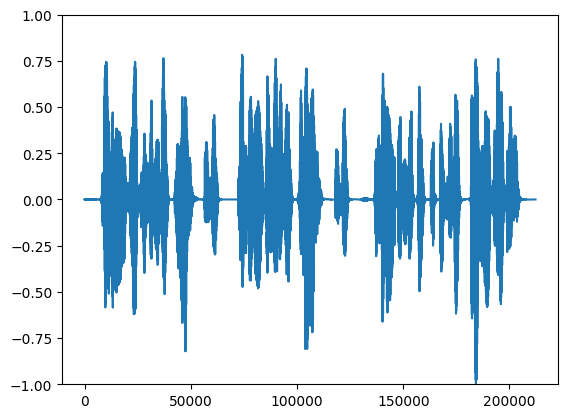

In [15]:
import matplotlib.pyplot as plt
wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

In [21]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    
def get_blendshape(wav, sid):
    mel = get_mel(torch.Tensor(wav).unsqueeze(0)).to(device)
    sid = torch.Tensor([sid]).long().to(device)
    with torch.no_grad():
        y = model.inference(mel, sid=sid)
    y = y[0].data.cpu().numpy()
    return mel[0].data.cpu().numpy(), y
    
ys = []
for sid in range(1, 8):
    mel, y = get_blendshape(wav, sid)
    ys.append(y)
    
ys = np.stack(ys)
print(ys.shape)

np.save('samples/infer08.14-1.npy', ys)
print('done')

(7, 61, 265)
done


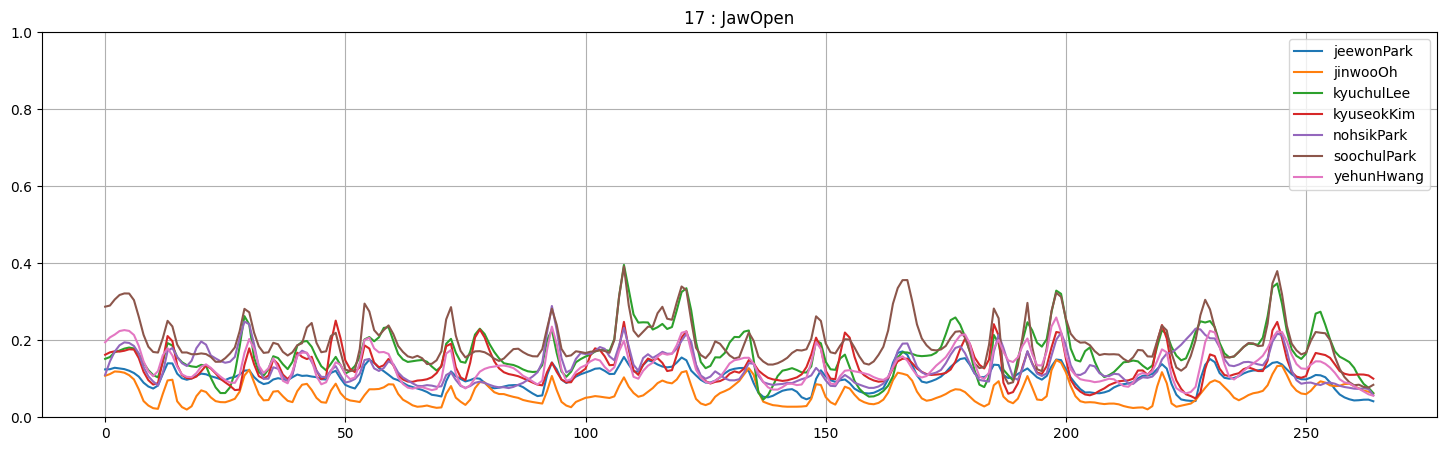

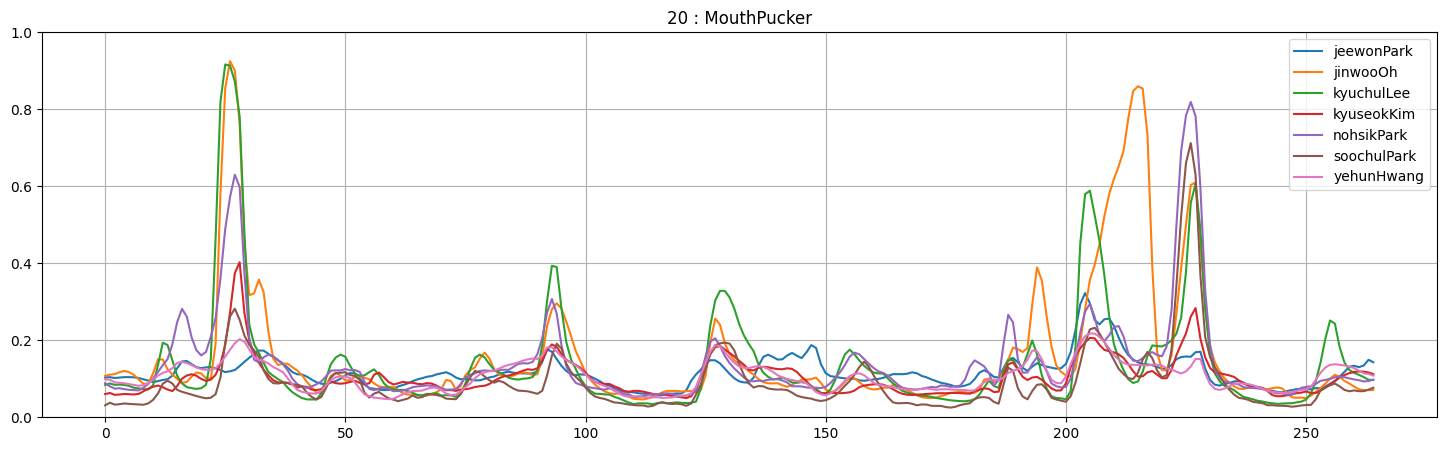

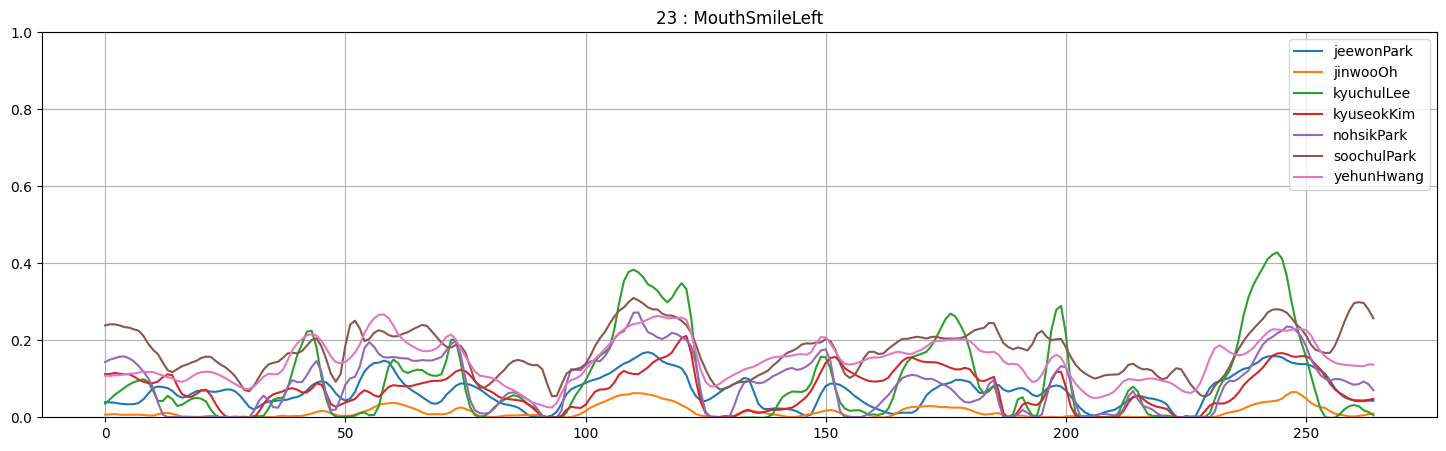

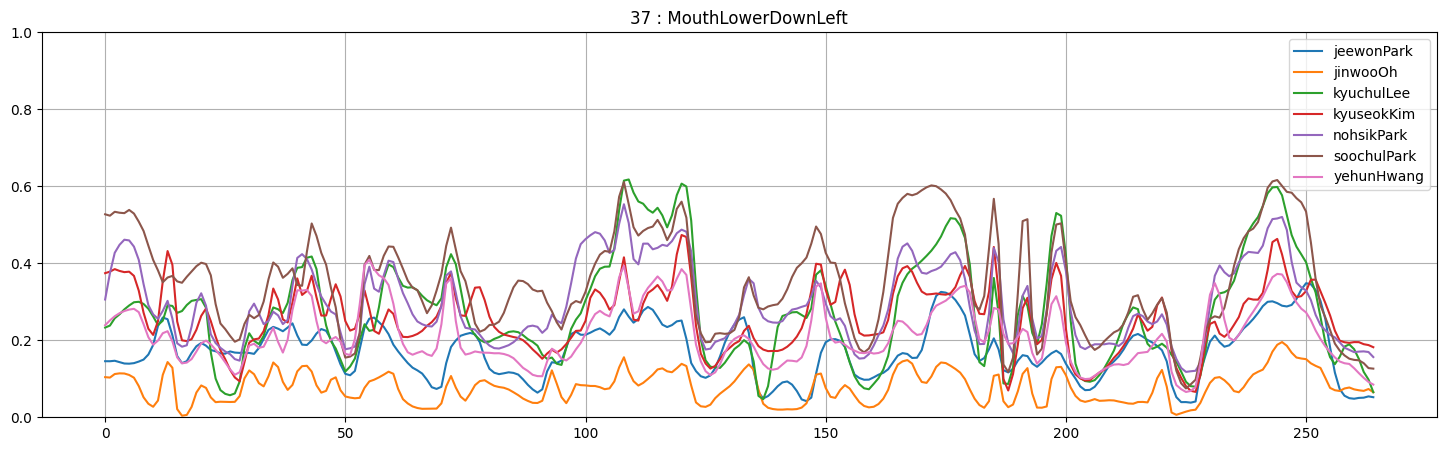

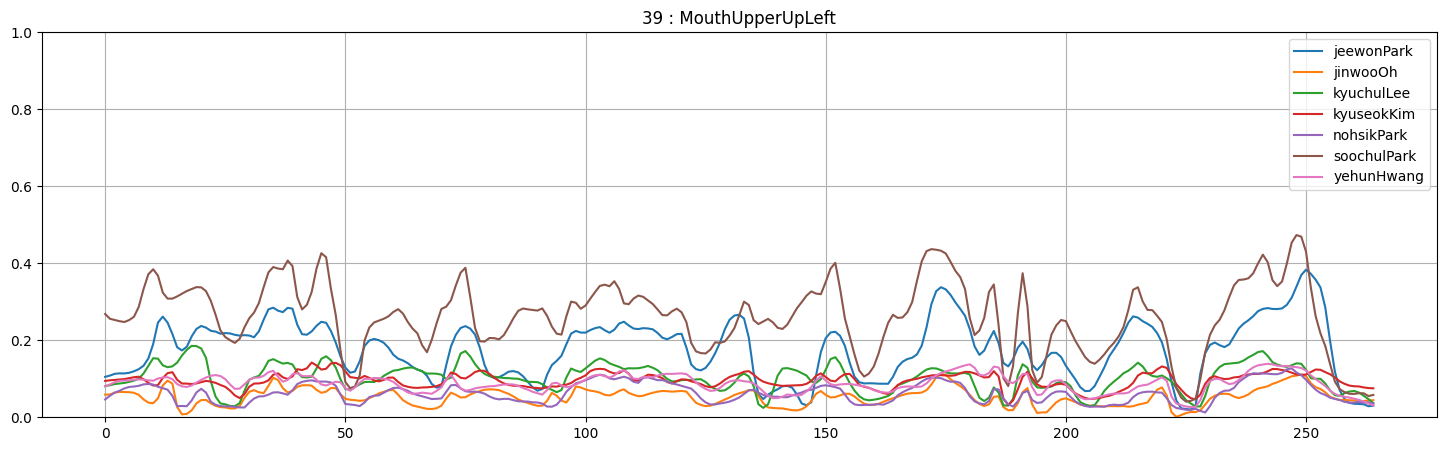

In [19]:
names = ['jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']

plt.figure(figsize=[18, 5])
plt.title('17 : JawOpen')
for i in range(len(ys)):
    plt.plot(ys[i][17], label=names[i])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()


plt.figure(figsize=[18, 5])
plt.title('20 : MouthPucker')
for i in range(len(ys)):
    plt.plot(ys[i][20], label=names[i])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[18, 5])
plt.title('23 : MouthSmileLeft')
for i in range(len(ys)):
    plt.plot(ys[i][23], label=names[i])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[18, 5])
plt.title('37 : MouthLowerDownLeft')
for i in range(len(ys)):
    plt.plot(ys[i][37], label=names[i])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[18, 5])
plt.title('39 : MouthUpperUpLeft')
for i in range(len(ys)):
    plt.plot(ys[i][39], label=names[i])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()